<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/Deep%20Learning%20Project/%EC%97%AC%EB%9F%AC_%EC%9D%98%EC%83%81%EC%82%AC%EC%A7%84%EC%97%90%EC%84%9C_%EC%98%B7_%EC%A2%85%EB%A5%98_%EA%B5%AC%EB%B6%84(%EB%A9%80%ED%8B%B0%EB%A0%88%EC%9D%B4%EB%B8%94%EB%B6%84%EB%A5%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 여러 의상사진에서 옷 종류 구분 / 멀티레이블분류 문제 
## 데이터  
- fashion MNIST

## 목표
- 멀티 클래스와 멀티레이블 구분
- 이미지 확장 
- 이미지에 객체 삽입



In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 데이터전처리

### 데이터 불러오기 및 기본적 형태 확인

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
((train_images, train_labels), (test_images, test_labels))= fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")
print(f"test_images.shape: {test_images.shape}")
print(f"test_labels.shape: {test_labels.shape}")

train_images.shape: (60000, 28, 28)
train_labels.shape: (60000,)
test_images.shape: (10000, 28, 28)
test_labels.shape: (10000,)


In [4]:
# 레이블 설정
labels = ["T-shirt/top",  # index 0
        "Trouser",      # index 1
        "Pullover",     # index 2 
        "Dress",        # index 3 
        "Coat",         # index 4
        "Sandal",       # index 5
        "Shirt",        # index 6 
        "Sneaker",      # index 7 
        "Bag",          # index 8 
        "Ankle boot"]   # index 9

def idx2label(idx):
    return labels[idx]

In [5]:
idx2label(test_labels[0])

'Ankle boot'

In [6]:
def show(idx):
    plt.imshow(train_images[idx], cmap = "gray")
    plt.title(idx2label(train_labels[idx]))
    plt.show()

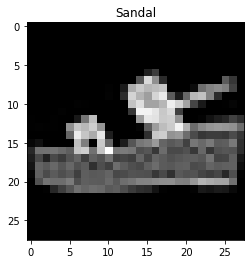

In [7]:
show(12)

### 이미지 데이터의 범위 확인

In [8]:
train_images[train_images != 0  ][:5]

array([ 1, 13, 73,  1,  4], dtype=uint8)

In [9]:
# 이미지의 값이 가장 큰 idx와 작은 idx를 구하여 출력
print(train_images.reshape((60000, -1)).sum(axis=1).argmax())
print(train_images.reshape((60000, -1)).sum(axis=1).argmin())

55023
9230


In [10]:
print(train_images.reshape((60000, -1)).sum(axis=1)[55023])
print(train_images.reshape((60000, -1)).sum(axis=1)[9230])

150387
3876


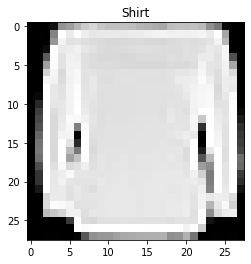

In [11]:
show(55023)

In [12]:
# train_images 타입
train_images.dtype

dtype('uint8')

In [13]:
# train/test 전체 데이터에서 각 images, labels의 min, max를 출력
print(  train_images.min(), train_images.max()  )
print(  test_images.min(), test_images.max()  )

print(  train_labels.min(), train_labels.max()  )
print(  test_labels.min(), test_labels.max()  )

0 255
0 255
0 9
0 9


In [15]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

###  데이터 0-1 노말라이즈 

In [16]:
def norm(data):
    min_v = data.min()
    max_v = data.max()
    return (data - min_v)/(max_v - min_v)

In [23]:
train_images  = norm(train_images)

In [19]:
test_images  = norm(test_images)

In [20]:
print(  test_images.min(), test_images.max()  )

0.0 1.0


In [24]:
print(f"train_images: {train_images[train_images !=0][:10]}")
print(f"test_images: {test_images[test_images !=0][:10]}")

train_images: [0.00392157 0.05098039 0.28627451 0.00392157 0.01568627 0.00392157
 0.00392157 0.01176471 0.14117647 0.53333333]
test_images: [0.01176471 0.00392157 0.02745098 0.14509804 0.00392157 0.00784314
 0.10588235 0.32941176 0.04313725 0.46666667]


## Step 2. 시각화

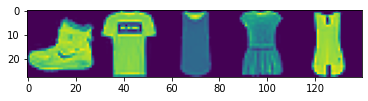

In [26]:
# transpose 이용하여 이미지 출력
plt.imshow(train_images[:5].transpose((1, 0, 2)).reshape((28, -1)))

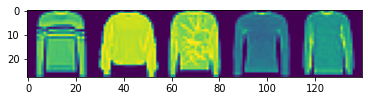

In [27]:
# 레이블에 따라 이미지 출력
# argwhere

plt.imshow(  train_images[ np.argwhere(  train_labels ==  2  )[:5, ..., 0]  ] . transpose((1, 0, 2)).reshape((28, -1)) )

In [28]:
# 레이블에 따라 이미지 출력 함수
def filter(label, count = 5):
    imgs =  train_images[ np.argwhere(  train_labels == label  )[:count, ..., 0]  ] . transpose((1, 0, 2)).reshape((28, -1)) 
    plt.imshow(imgs)
    plt.show()

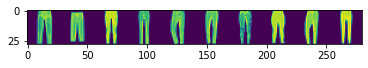

In [29]:
filter(1, 10)

## Step3. Data augmentation - 이미지 확대 및 다객체 추가

In [30]:
# 이미지 4배 확장하고, 랜덤으로 이미지 공간 삽입

def expand_4times(img):
    bg = np.zeros(img.shape)
    idx = np.random.randint(0, 4)
    
    slots = [bg, bg, bg, bg] 
    slots[idx] = img 
    expanded = np.vstack([
                          np.hstack(slots[:2]),
                          np.hstack(slots[2:])
    ]) 
    return expanded

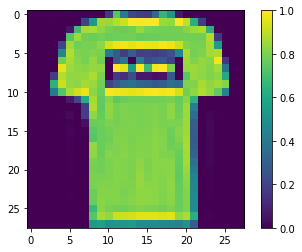

In [31]:
plt.imshow(train_images[1])
plt.colorbar()

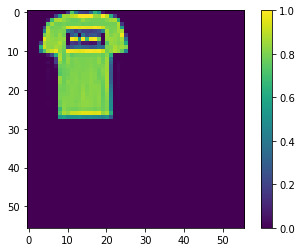

In [32]:
plt.imshow(expand_4times(train_images[1]))
plt.colorbar()

###  4배 이미지 변환을 전체 train/test 데이터에 실행

In [33]:
train_expand_images = np.array([expand_4times(img) for img in train_images])
test_expand_images = np.array([expand_4times(img) for img in test_images])

In [34]:
print(test_expand_images.shape, train_expand_images.shape) 
print(test_expand_images.dtype, train_expand_images.dtype)

print(test_expand_images.min(), train_expand_images.min())
print(test_expand_images.max(), train_expand_images.max())

(10000, 56, 56) (60000, 56, 56)
float64 float64
0.0 0.0
1.0 1.0


###  4배 이미지 변환 함수에 객체를 랜덤으로 4분면에 위치시키는 함수

In [35]:
def expand_4times2(x_data, y_data):
    images = []
    labels = []

    for _ in range(4):
        bg = np.zeros((28, 28))
        obj_count = np.random.randint(0, 5)

        label = np.zeros((10,)) 
        slots = [bg, bg, bg, bg]

        for idx in range(obj_count):
            i = np.random.randint(len(x_data))
            slots[idx] = x_data[i]
            label += tf.keras.utils.to_categorical(y_data[i], 10) 
            
        np.random.shuffle(slots) 

    new_img = np.vstack([
                          np.hstack(slots[:2]),
                          np.hstack(slots[2:])
    ])
    images.append(new_img)
    labels.append((label >= 1 ).astype(np.int)) 
    return np.array(images), np.array(labels)

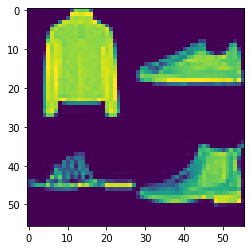

In [42]:
plt.imshow(  expand_4times2(train_images, train_labels)[0][0]  )

In [37]:
expand_4times2(train_images, train_labels)[1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 4배 이미지 변환을 전체 train/test 데이터에 실행

In [43]:
train_multi_images, train_multi_labels = list(zip(*[expand_4times2(train_images, train_labels) for i in train_images]))
test_multi_images, test_multi_labels = list(zip(*[expand_4times2(test_images, test_labels) for i in test_images]))

In [44]:
# list형태 numpy 형태로 변경
train_multi_images = np.array(train_multi_images)[:, 0, :, :].reshape(-1, 56, 56, 1)
train_multi_labels = np.array(train_multi_labels)[:, 0, :]

test_multi_images = np.array(test_multi_images)[:, 0, :, :].reshape(-1, 56, 56, 1)
test_multi_labels = np.array(test_multi_labels)[:, 0, :]

In [45]:
print(train_multi_images.shape, train_multi_labels.shape)
print(test_multi_images.shape, test_multi_labels.shape)

(60000, 56, 56, 1) (60000, 10)
(10000, 56, 56, 1) (10000, 10)


## Step 4.모델링

In [46]:
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, Flatten, GlobalAvgPool2D
from keras.models import Model

In [56]:
def multi_fashin_mnist_model():
    inputs = Input((56, 56, 1))
    x = Conv2D(16, 2, padding="same", activation="relu")(inputs)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, 2, padding="same", activation="relu")(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, 2, padding="same", activation="relu")(x)
    x = MaxPool2D(2)(x)
    x = GlobalAvgPool2D()(x)

    x = Dense(10, activation='sigmoid')(x) 
    return Model(inputs, x)

In [57]:
model = multi_fashin_mnist_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0     

In [58]:
model.get_weights()[0]

array([[[[ 0.09169334,  0.06302923, -0.11072433,  0.02029762,
           0.11124933, -0.2523194 ,  0.02433619, -0.10509868,
          -0.06245977,  0.03762153, -0.07571404, -0.01635402,
           0.24659461,  0.05059806,  0.090152  , -0.00791842]],

        [[-0.00758329, -0.06986423, -0.13003434, -0.04072887,
           0.1746211 , -0.04464236,  0.0416511 , -0.09833747,
          -0.06940807, -0.07218765,  0.13629767,  0.21690583,
          -0.20905267, -0.2769701 , -0.15007985,  0.01551849]]],


       [[[-0.16498318, -0.06349559, -0.25699535, -0.11534263,
          -0.15190816, -0.1405494 , -0.00298765, -0.26626828,
           0.26167047,  0.10950634, -0.13362788, -0.1895639 ,
           0.12444538, -0.09749797,  0.17156959, -0.2340664 ]],

        [[ 0.2797159 ,  0.1911146 , -0.16898853,  0.19071919,
          -0.24942276,  0.19890347,  0.24713701,  0.06991217,
          -0.17871371, -0.0791242 ,  0.16650745,  0.05384222,
          -0.15208592,  0.19506413, -0.00644422,  0.2048094

In [59]:
train_multi_images.shape, train_multi_labels.shape

((60000, 56, 56, 1), (60000, 10))

## Step 5. 학습 및 결과 

In [61]:
# 멀티클레스 레이블 모델 학습.

epochs = 15
batch_size = 32
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
for epoch in range(epochs):
    for _ in range(0, len(train_images), batch_size):
        batch_x = []
        batch_y = []
        for _ in range(batch_size):
            x, y = expand_4times2(train_images, train_labels)
            batch_x.append(x)
            batch_y.append(y)

        batch_x = np.array(batch_x).reshape((-1, 56, 56, 1))
        batch_y = np.array(batch_y).reshape((-1, 10))
        model.train_on_batch(batch_x, batch_y)
    print(epoch, "e")

0 e
1 e
2 e
3 e
4 e
5 e
6 e
7 e
8 e
9 e
10 e
11 e
12 e
13 e
14 e


In [72]:
res = model.predict(test_multi_images[6].reshape((1,56,56,1)))
res.shape

(1, 10)

<BarContainer object of 10 artists>

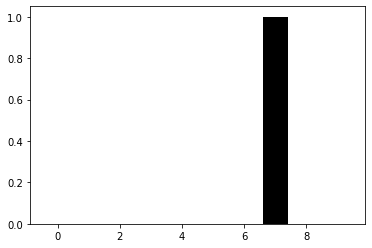

In [74]:
plt.bar(np.arange(0, 10),    test_multi_labels[6], color="black")

<BarContainer object of 10 artists>

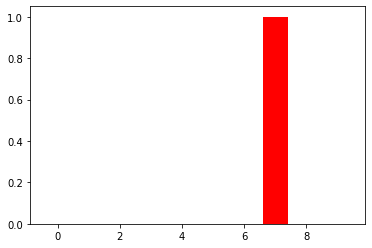

In [75]:
plt.bar(np.arange(0, 10), res[0] > 0.5, color="red")

In [68]:
res

array([[0.02187647, 0.01412443, 0.03797625, 0.30555412, 0.22315173,
        0.16146487, 0.1556168 , 0.18393162, 0.17824546, 0.98742664]],
      dtype=float32)

## Step 6. 모델 저장 및 로드, 다운

In [76]:
model.save('./lecture008-multilabel.h5')

In [78]:
model2 = tf.keras.models.load_model('./lecture008-multilabel.h5')

In [79]:
# 로드한 모델을 test 데이터로 평가
loss, acc = model2.evaluate(test_expand_images.reshape((-1, 56,56, 1)), tf.keras.utils.to_categorical(test_labels))
print(loss, acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.1648 - accuracy: 0.7634
0.16478343307971954 0.7634000182151794


In [81]:
# 모델 컴퓨터에 저장
from google.colab import files
files.download('./lecture008-multilabel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>